## Problem statement:

Developing a CNN-based model that can accurately detect melanoma is crucial. Melanoma is a type of cancer that can be deadly if not identified early, accounting for 75% of skin cancer deaths. A system capable of evaluating images and alerting dermatologists to the presence of melanoma could significantly reduce the manual effort required in diagnosis


In [ ]:
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!pip install tensorflow==2.17

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 114.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 111.3 MB/s eta 0:00:00
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalling tensorflow-2.8.0:
      Successfully uninstal

In [ ]:
# import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Setting the path for trained & test images
data_dir_train = pathlib.Path(
    "/content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path(
    "/content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [ ]:
# Counting number of images in Trained and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

# Counting trained image
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

# Counting test image count
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


**Data Visualization Section**


Found 2239 files belonging to 9 classes.


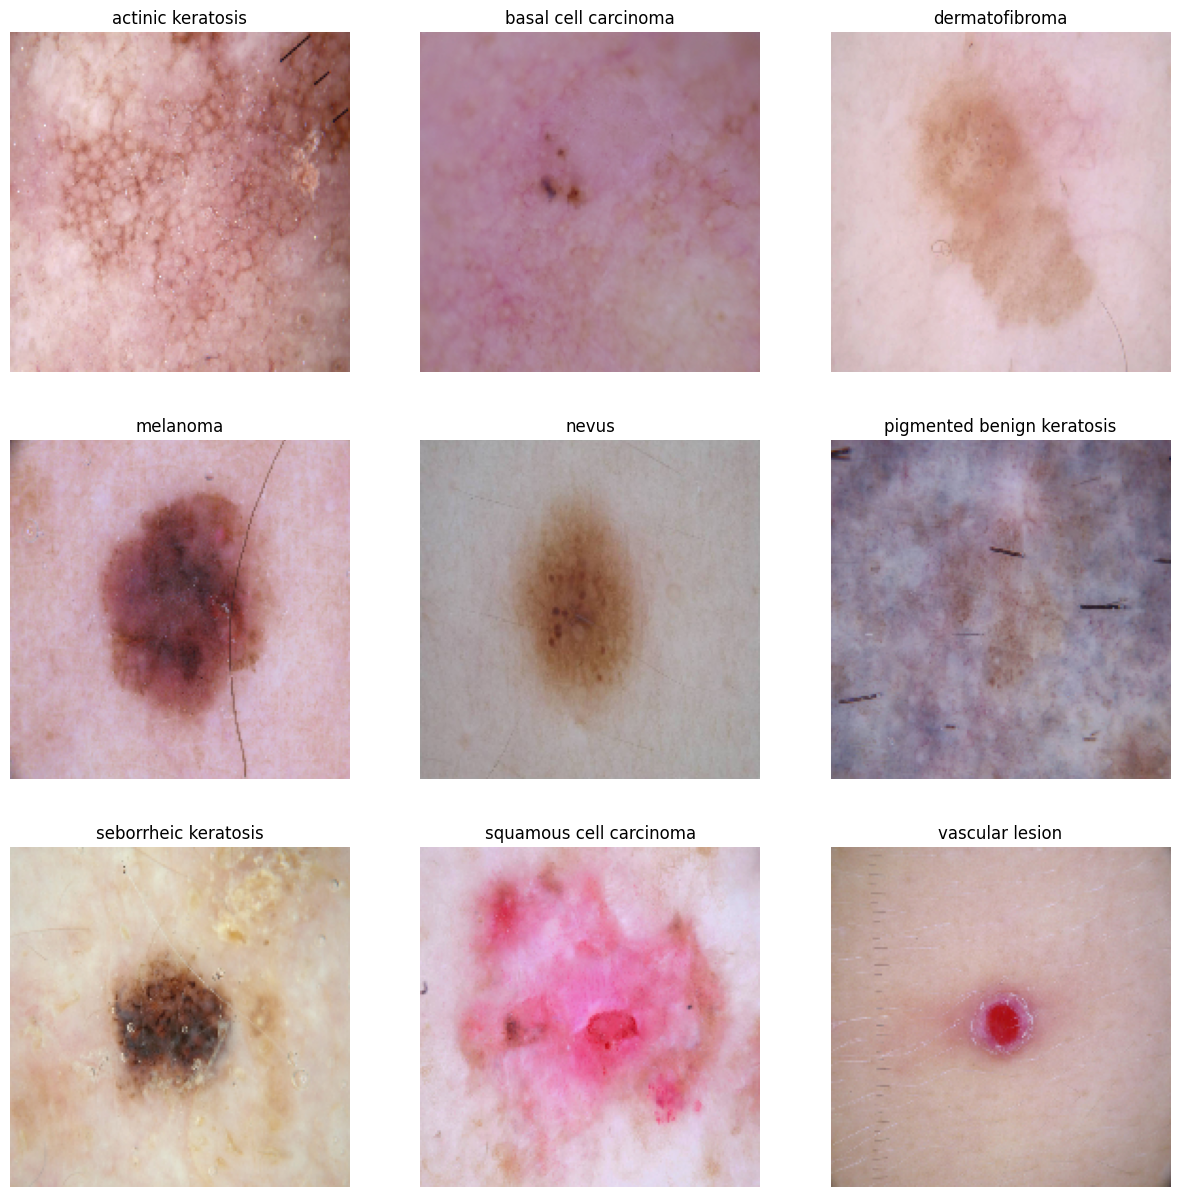

In [ ]:
# Visualizing one instance of all the class present in the dataset.

# image_dataset_from_directory() will return a tf.data.Dataset that yields batches of images from the subdirectories.
# label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes), representing a one-hot encoding of the class index.
image_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32, image_size=(180, 180),
                                                                    label_mode='categorical', seed=123)

# all the classes of Skin Cancer
class_names = image_dataset.class_names

# Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x: str(
        data_dir_train)+'/'+c+'/'+x, os.listdir(str(data_dir_train)+'/'+c)))

# Visualizing image
plt.figure(figsize=(15, 15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(load_img(path_list[0], target_size=(180, 180)))
    plt.title(c)
    plt.axis("off")

**Visualizing distribution of classes in the training data.**


In [ ]:
def class_distribution_count(directory):

    # counting number of images in each classes
    count = []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                              if os.path.isfile(os.path.join(path, name))]))

    # name of the classes
    sub_directory = [name for name in os.listdir(directory)
                     if os.path.isdir(os.path.join(directory, name))]

    # return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory, count)), columns=['Class', 'No. of Image'])


df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,vascular lesion,139
1,actinic keratosis,114
2,basal cell carcinoma,376
3,nevus,357
4,melanoma,438
5,squamous cell carcinoma,181
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,dermatofibroma,95


<Axes: xlabel='No. of Image', ylabel='Class'>

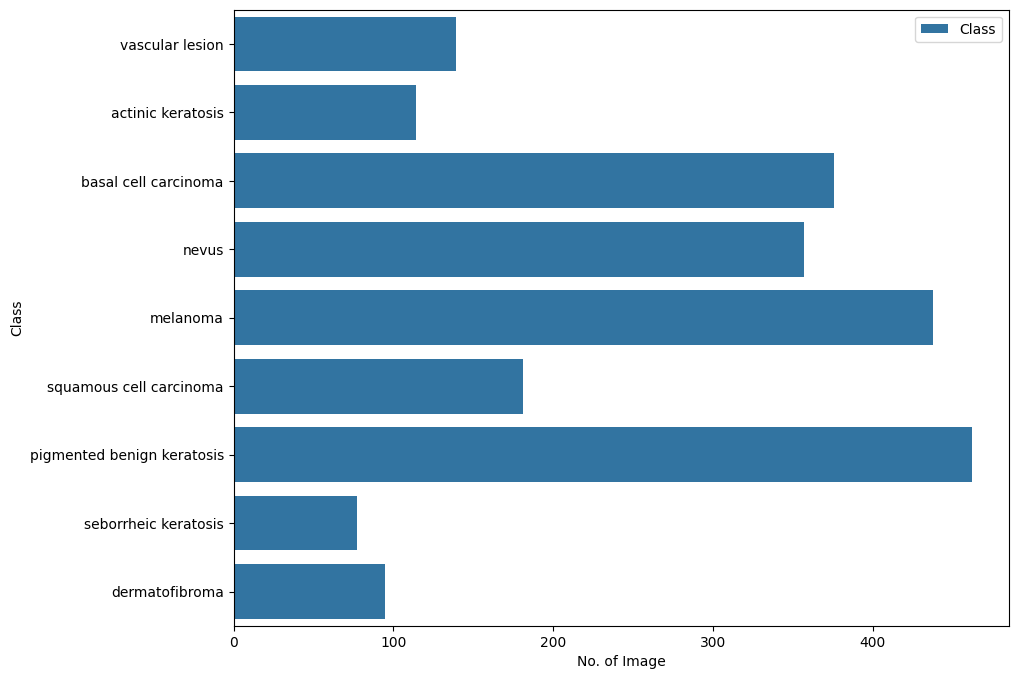

In [ ]:
# Visualizing the number of images in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

There is a class imbalance issue. To address this, the Augmentor Python package (https://augmentor.readthedocs.io/en/master/) can be used to add more samples across all classes, ensuring that no class is left with very few samples


In [ ]:
#installing Augmentor
!pip install Augmentor

In [ ]:
import Augmentor
path_to_training_dataset = "/content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    # Adding 500 samples per class to make sure that none of the classes are sparse
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9A241F6920>: 100%|██████████| 500/500 [00:20<00:00, 24.84 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7C9A004FFAC0>: 100%|██████████| 500/500 [00:20<00:00, 24.13 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9A141439D0>: 100%|██████████| 500/500 [00:22<00:00, 22.32 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7C9A241A23E0>: 100%|██████████| 500/500 [01:30<00:00,  5.56 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x7C9A00091030>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9A005A19F0>: 100%|██████████| 500/500 [00:19<00:00, 25.35 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7C9A25B789D0>: 100%|██████████| 500/500 [00:39<00:00, 12.61 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9A1413DCF0>: 100%|██████████| 500/500 [00:19<00:00, 25.04 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/dataset/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7C9A005A2B00>: 100%|██████████| 500/500 [00:20<00:00, 24.87 Samples/s]


In [ ]:
# Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Model Building**


In [ ]:
# train dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180, 180), label_mode='categorical',
                                                               seed=123, subset="training",
                                                               validation_split=0.2)

# label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
# representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [ ]:
# validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                             image_size=(180, 180), label_mode='categorical',
                                                             seed=123, subset="validation",
                                                             validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [ ]:
# tf.data.experimental.AUTOTUNE defines appropriate number of processes that are free for working.

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

# Define the number of classes (adjust `num_classes` as per your dataset)
# Ensure `class_names` is defined, or replace with an integer.
num_classes = len(class_names)

# Create the CNN model
model = Sequential()

# Rescaling Layer (normalize pixel values to the range [0, 1])
model.add(layers.Rescaling(1./255, input_shape=(180, 180, 3)))

# First Convolutional Layer
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Second Convolutional Layer
model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Third Convolutional Layer
model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout Layer (50% dropout rate)
model.add(layers.Dropout(0.5))

# Flatten Layer (convert 3D feature maps to 1D feature vectors)
model.add(layers.Flatten())

# Fully Connected Dense Layer
model.add(layers.Dense(128, activation='relu'))

# Dropout Layer (25% dropout rate)
model.add(layers.Dropout(0.25))

# Output Dense Layer with softmax activation
model.add(layers.Dense(num_classes, activation='softmax'))

# Print the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       6,553,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │           1,161 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

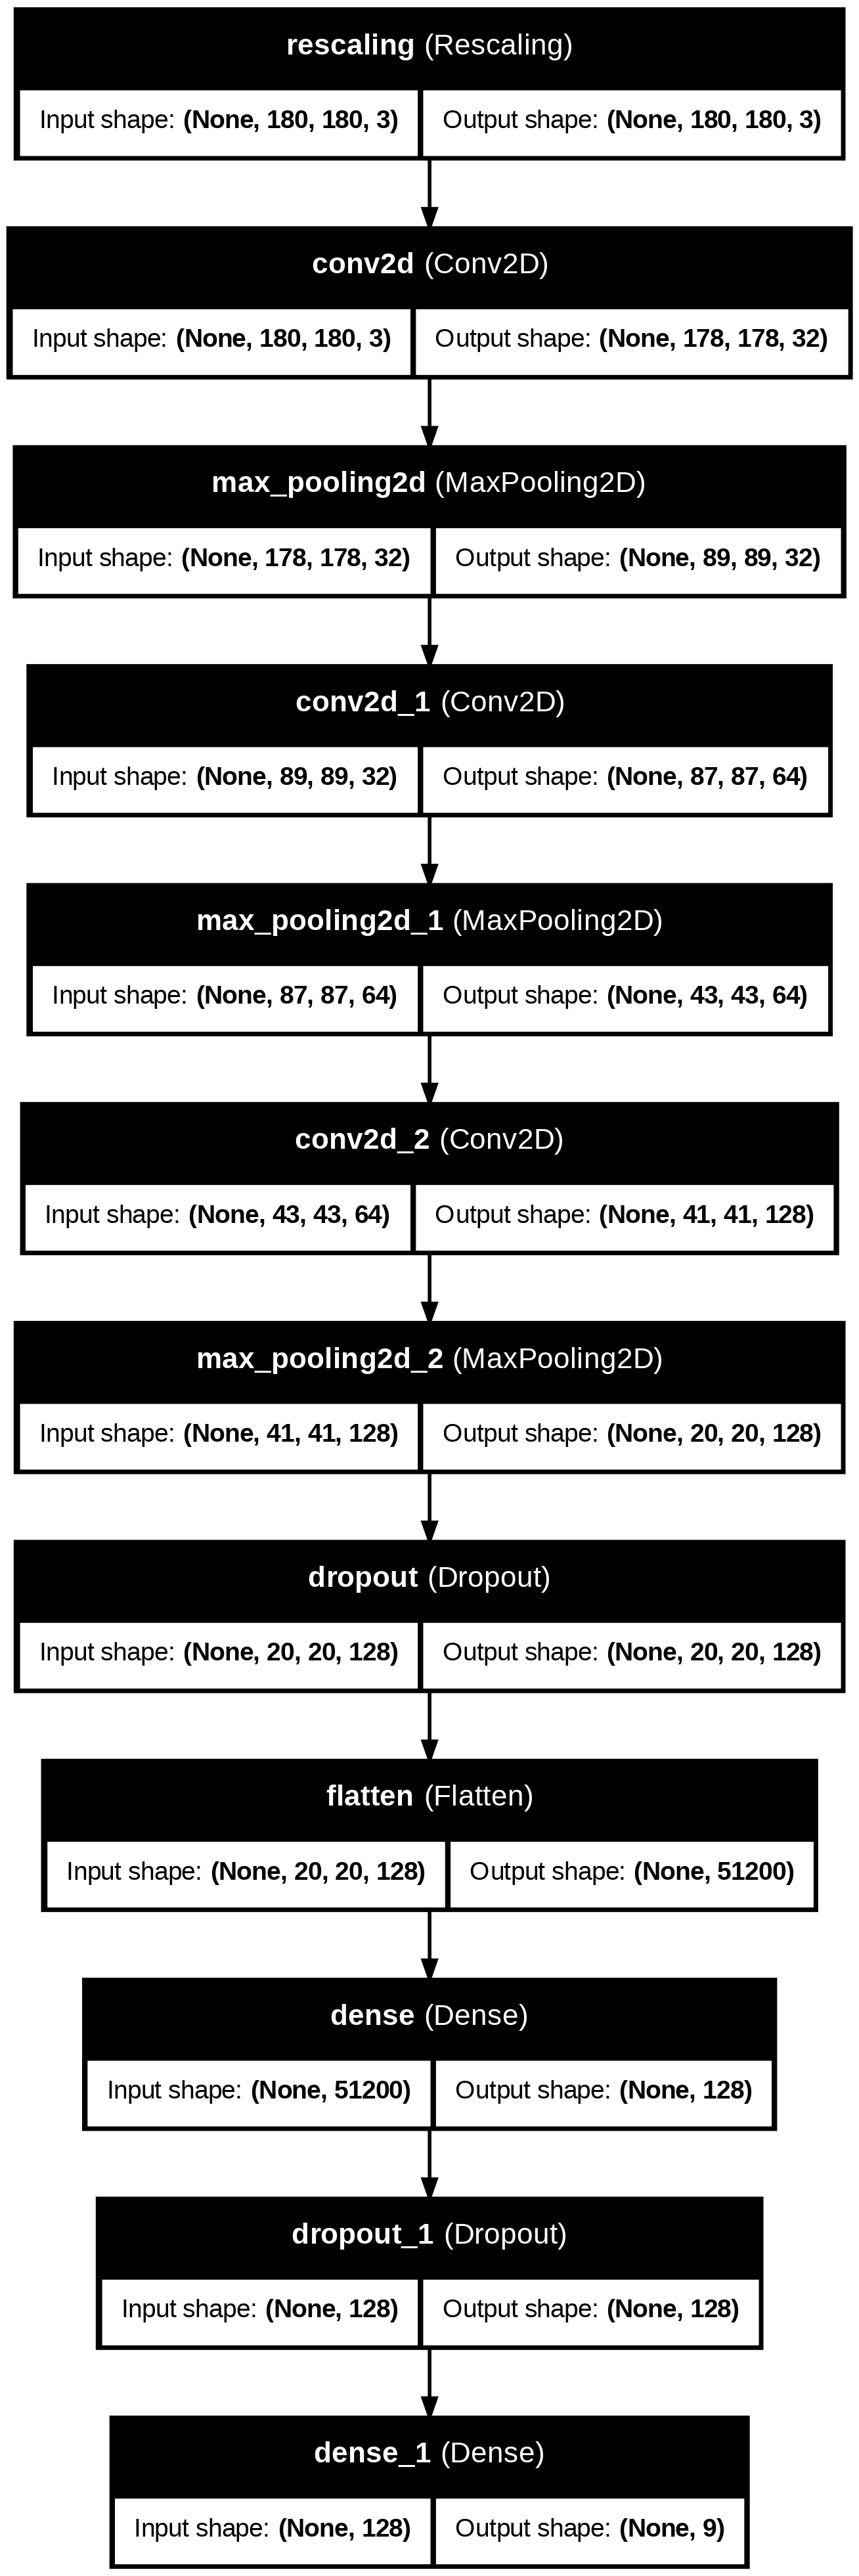

In [ ]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
# Compile the Model

# Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
# categorical_crossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

model.compile(optimizer="Adam", loss="categorical_crossentropy",
              metrics=["accuracy"])

# ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
# so the model or weights can be loaded later to continue the training from the state saved.
checkpoint = ModelCheckpoint(
    "model.keras", monitor="val_accuracy", save_best_only=True, mode="auto", verbose=1)

# Stop training when a monitored metric has stopped improving.
earlystop = EarlyStopping(monitor="val_accuracy",
                          patience=5, mode="auto", verbose=1)

In [ ]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds,
                    epochs=epochs, callbacks=[checkpoint, earlystop])

Epoch 1/20
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1831 - loss: 2.1405
Epoch 1: val_accuracy improved from -inf to 0.37936, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 64s 129ms/step - accuracy: 0.1840 - loss: 2.1381 - val_accuracy: 0.3794 - val_loss: 1.6727
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4037 - loss: 1.5827
Epoch 2: val_accuracy improved from 0.37936 to 0.48775, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.4038 - loss: 1.5824 - val_accuracy: 0.4878 - val_loss: 1.3425
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4887 - loss: 1.3828
Epoch 3: val_accuracy improved from 0.48775 to 0.54046, saving model to model.keras
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.4887 - loss: 1.3827 - val_accuracy: 0.5405 - val_loss: 1.1991
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5430 - loss: 1.2321
Epoch 4: val_accuracy improved from 0.54046 to

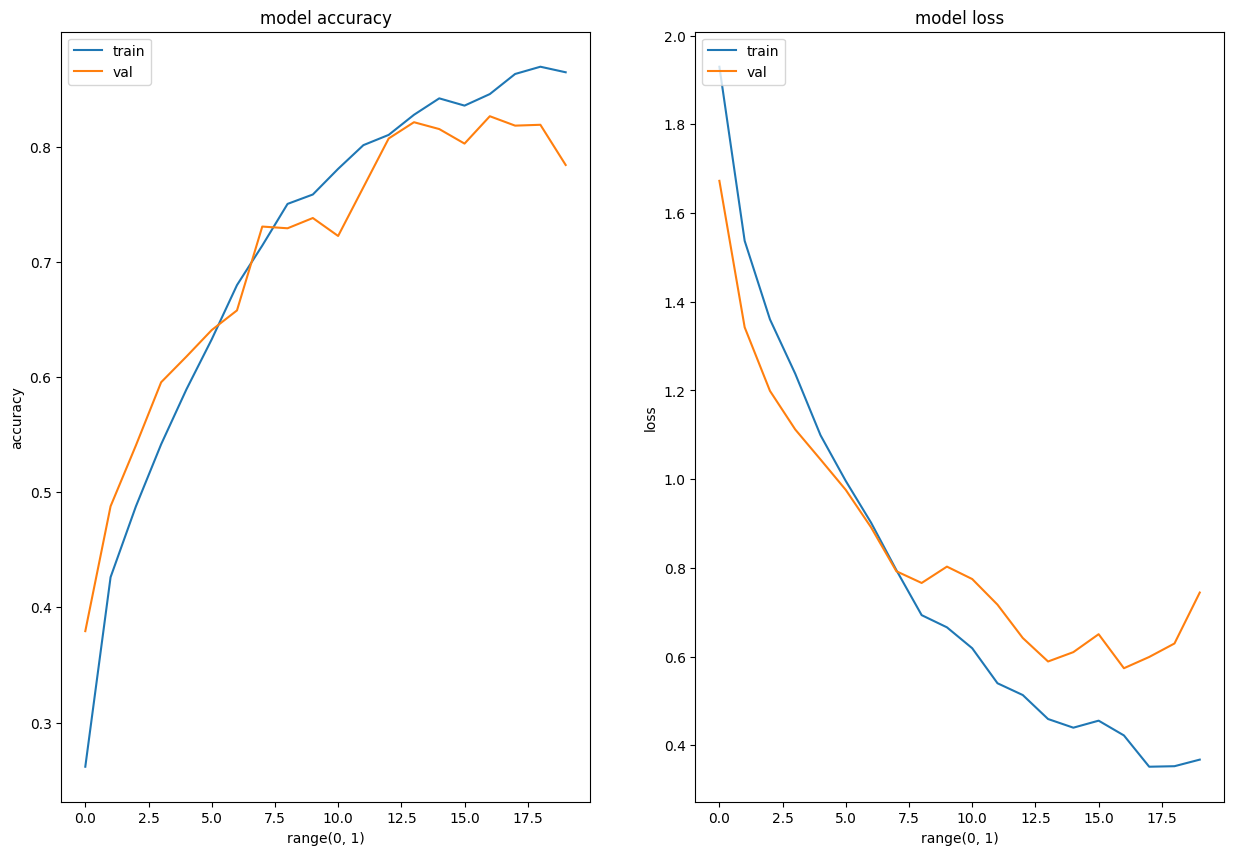

In [ ]:
# Plot the training curves

epochs_range = range(earlystop.stopped_epoch+1)

plt.figure(figsize=(15, 10))
plt.subplot(1, 2, 1)

# Plot Model Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')

# Plot Model Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel(epochs_range)
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Model Prediction


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 815ms/step
Actual Class basal cell carcinoma
Predictive Class basal cell carcinoma


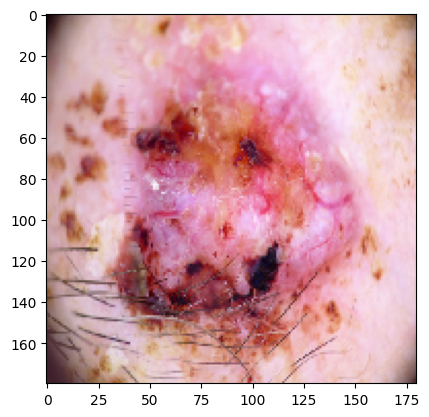

In [ ]:
from glob import glob
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1], target_size=(180, 180, 3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image, axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class " + class_names[1] + '\n' + "Predictive Class "+pred_class)